[  0   0   0 ... 999 999 999]
The empirical selective accuracy is: 0.9130865175212829
_imgs shapes: [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]
_imgs shapes: [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]
selective_risk_ub() 0.18363887842751017


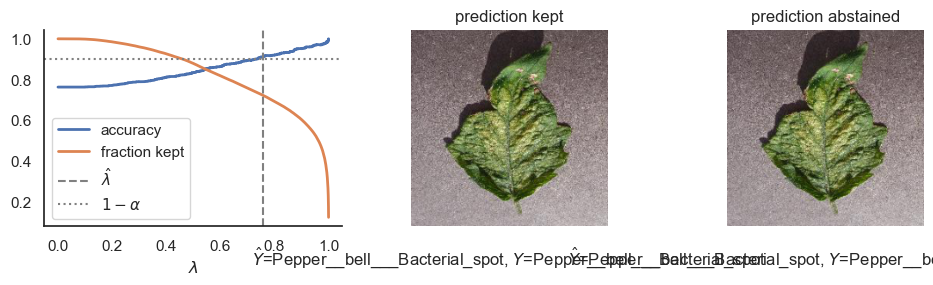

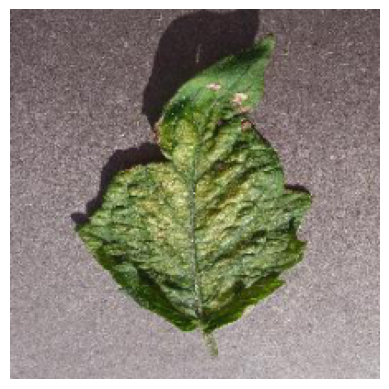

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


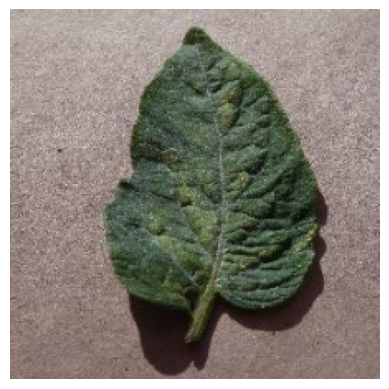

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


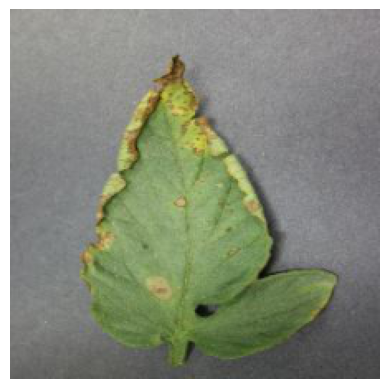

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


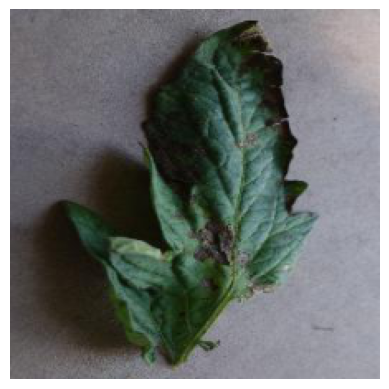

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


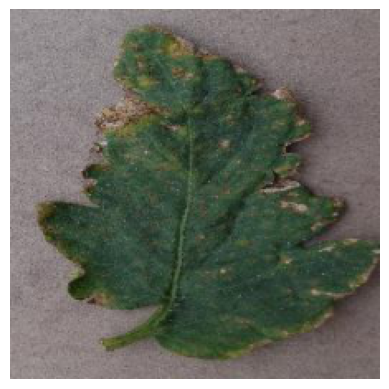

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


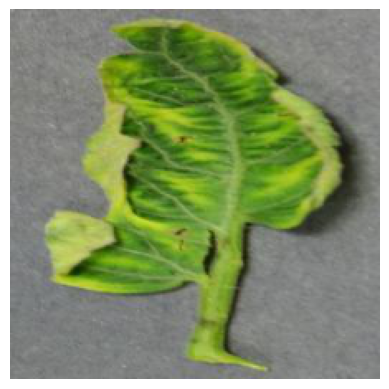

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


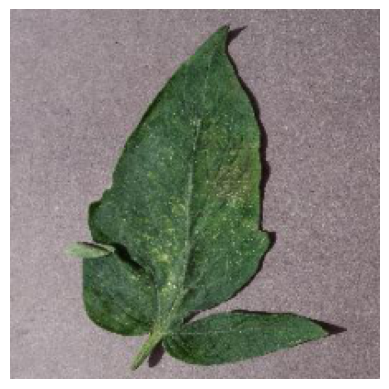

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: False


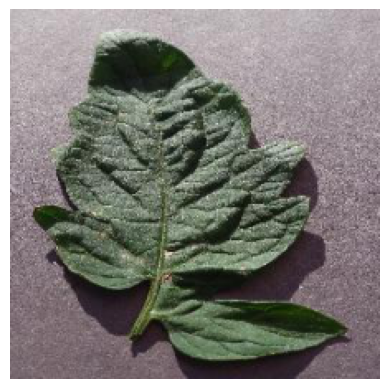

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


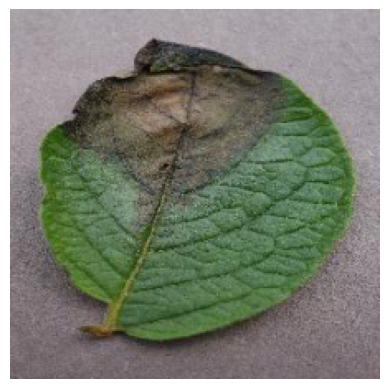

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: False


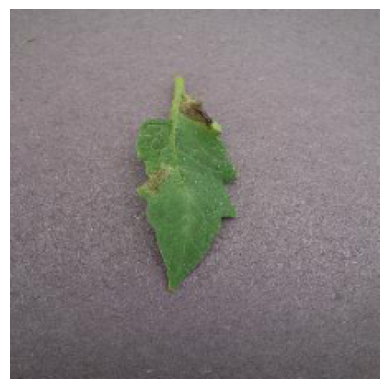

Prediction: Pepper__bell___Bacterial_spot | Label: Pepper__bell___Bacterial_spot | Abstained: True


In [2]:
import os
import json
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.optimize import brentq
from scipy.stats import binom
import seaborn as sns
from skimage.transform import resize

# Change the path to the new location
data_path = r'C:\Personal\Confirmal Prediction\data(1).tar.gz'

# Load cached data
if not os.path.exists('../data'):
    os.system(f'gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O {data_path}')
    os.system(f'tar -xf {data_path} -C ../')
    os.system(f'rm {data_path}')
labels_path = r'C:\Personal\Confirmal Prediction\data\imagenet\cleaned.json'
os.makedirs(os.path.dirname(labels_path), exist_ok=True)

if not os.path.exists(labels_path):
    labels_url = 'https://gist.github.com/saumil-16/7ed747f7fd4292ac00ef40fa3a23b176'
    print(urlretrieve(labels_url, labels_path))
data = np.load('../data/imagenet/imagenet-resnet152.npz') # trained model
#a. Model (CondenseNet, skipNet, DynNet)
#b. Training and Test
#c. Selective classification
example_paths = os.listdir('../data/imagenet/leaf/PlantVillage/images/')
smx = data['smx']
labels = data['labels'].astype(int)
print(labels)
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired selective accuracy
delta = 0.1 # delta is the failure rate
lambdas = np.linspace(0,1,5000)
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
# Yhat, Phat
cal_yhats = np.argmax(cal_smx,axis=1); val_yhats = np.argmax(val_smx,axis=1);
cal_phats = cal_smx.max(axis=1); val_phats = np.max(val_smx,axis=1);
# Define selective risk
def selective_risk(lam): return (cal_yhats[cal_phats >= lam] != cal_labels[cal_phats >= lam]).sum()/(cal_phats >= lam).sum()
def nlambda(lam): return (cal_phats > lam).sum()
lambdas = np.array([lam for lam in lambdas if nlambda(lam) >= 30]) # Make sure there's some data in the top bin.
def invert_for_ub(r,lam): return binom.cdf(selective_risk(lam)*nlambda(lam),nlambda(lam),r)-delta
# Construct upper boud
def selective_risk_ub(lam): return brentq(invert_for_ub,0,0.9999,args=(lam,))
# Scan to choose lamabda hat
for lhat in np.flip(lambdas):
    if selective_risk_ub(lhat-1/lambdas.shape[0]) > alpha: break
# Deploy procedure on test data
predictions_kept = val_phats >= lhat
# Calculate empirical selective accuracy
empirical_selective_accuracy = (val_yhats[predictions_kept] == val_labels[predictions_kept]).mean()
print(f"The empirical selective accuracy is: {empirical_selective_accuracy}")
false_flags = (val_yhats[~predictions_kept] == val_labels[~predictions_kept]).mean()
#print(f"The fraction of false flags is: {false_flags}")
fraction_kept = predictions_kept.mean()
#print(f"The fraction of data points kept is: {fraction_kept}")
from skimage.transform import resize

# Get some examples
with open('../data/imagenet/cleaned.json') as f:
    label_strings = np.array(json.load(f))

example_paths = os.listdir('../data/imagenet/leaf/PlantVillage/images/')
_imgs = []
_keeps = []
_yhats = []
_labels = []
target_shape = (224, 224, 3)  # Set your desired target shape, considering RGB images

for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread('../data/imagenet/leaf/PlantVillage/images/' + rand_path)
    img_resized = resize(img, target_shape, anti_aliasing=True)
    
    _imgs.append(img_resized)
    img_index = int(rand_path.split('.')[0])
    _keeps.append(np.max(smx[img_index]) >= lhat)
    _yhats.append(label_strings[np.argmax(smx[img_index])])
    _labels.append(label_strings[labels[img_index]])

# Print shapes before converting to NumPy arrays
print("_imgs shapes:", [img.shape for img in _imgs])

# Convert to NumPy arrays
_imgs = np.array(_imgs)
_keeps = np.array(_keeps)
_yhats = np.array(_yhats)
_labels = np.array(_labels)


# Print shapes before converting to NumPy arrays
print("_imgs shapes:", [img.shape for img in _imgs])

# Convert to NumPy arrays
_imgs = np.array(_imgs)
_keeps = np.array(_keeps)
_yhats = np.array(_yhats)
_labels = np.array(_labels)


# Plot numerics and selected examples
sns.set(style='white')
selective_accuracy_curve = [1-selective_risk(lam) for lam in lambdas]
#print('selective_accuracy_curve',selective_accuracy_curve)
#print('selective_risk', selective_risk(lambdas[]))
#print('invert_for_ub', invert_for_ub)
print('selective_risk_ub()', selective_risk_ub(0.5))
fraction_kept_curve = [(val_phats >= lam).mean() for lam in lambdas]
fig, axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(lambdas,selective_accuracy_curve,label='accuracy',linewidth=2)
axs[0].plot(lambdas,fraction_kept_curve,label='fraction kept',linewidth=2)
axs[0].axvline(x=lhat,linewidth=1.5,linestyle='--',label=r'$\hat{\lambda}$',color='gray')
axs[0].axhline(y=1-alpha,linewidth=1.5,linestyle='dotted',label=r'$1-\alpha$',color='gray')
sns.despine(ax=axs[0],top=True,right=True)
axs[0].legend(loc='lower left')
axs[0].set_xlabel(r'$\lambda$')
true_nonabstention_idx = np.argmax( (_yhats == _labels) & (_keeps))
axs[1].set_title('prediction kept')
axs[1].imshow(_imgs[true_nonabstention_idx])
axs[1].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_nonabstention_idx]}, ' + r'$Y$' + f'={_labels[true_nonabstention_idx]}')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
sns.despine(ax=axs[1],top=True,right=True,left=True,bottom=True)
true_abstention_idx = np.argmax( (_yhats != _labels) & (~_keeps))
axs[2].set_title('prediction abstained')
axs[2].imshow(_imgs[true_abstention_idx])
axs[2].set_xlabel(r'$\hat{Y}$' + f'={_yhats[true_abstention_idx]}, ' + r'$Y$' + f'={_labels[true_abstention_idx]}')
axs[2].set_yticklabels([])
axs[2].set_xticklabels([])
sns.despine(ax=axs[2],top=True,right=True,left=True,bottom=True)
plt.tight_layout()
plt.savefig('../data/imagenet/selective-classification-results.pdf',dpi=60)
plt.show()
    
# Plot more examples
for i in range(len(_imgs)):
    plt.figure()
    plt.imshow(_imgs[i])
    plt.axis('off')
    plt.show()
    print(f"Prediction: {_yhats[i]} | Label: {_labels[i]} | Abstained: {_keeps[i]}")
    

In [3]:
pip install tensorflow keras


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/b0/b2/104733bb67fde86f3d10010f0b5c93cfa1d5bf552f904584cf9e5b3ba719/keras-3.0.5-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https:

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
